In [1]:
# imports
import matplotlib.pyplot as plt
import rebound
import numpy as np
#plt.style.use('paper')
from celmech.lie_transformations import FirstOrderGeneratingFunction
from celmech import Poincare
from celmech.nbody_simulation_utilities import reb_add_from_elements
from celmech.disturbing_function import get_fg_coefficients
from celmech.miscellaneous import sk

In [2]:
# constants
mu=3e-12 *125       # m_1/m_star
j, k = 100, 1       # j:j-k MMR (so this is a 20:19 resonance)
pomega = np.pi/2    # pericenter of outer test particle
phi = 2*np.pi/3     # Angle of conjunction relative to pericenter (resonant angle)

n = 2*np.pi         # mean motion of inner planet (is just 2*pi so period = 1)
n20 = n*(j-k)/j     # initial mean motion of outer particle (19/20*n) (at resonance value)
                    # completes 19 orbits in the same time the inner planet completes 20 orbits
dares = (j/(j-k))**(2/3)-1 # delta a_res-- distance between test particle and planet at resonance
deltan = 0          # delta n: deviation of mean motion from resonance
                    # this small value is added to n20 bc the planet isn't *exactly* at resonance

ec = 2*k/3/j        # crossing eccentricity, factor to normalize e
etilde = 0.1        # eccentricity ratio to crossing value (e/e_c)

e = etilde*ec       # eccentricity
deltat = 2/3/n20    # time to move delta a in y at a rate delta v, 
                    #   where v = a*delta_n and delta_n = n2-n1
                    #   Goal: to find how far back to integrate

tconj=j/k           # time between conjunctions-- big if delta n is small
# ps[1].P = 1

epsilon = (1/3*mu)**(1/3) # small mass parameter

# coefficient values from Namouni paper
W1 = 3.359350011
W2 = 2.678665722
W3 = 2.639498803
W4 = 2.8559
W5 = 3.2594
W6 = 3.8508
W7 = 4.6616
W8 = 5.7459

In [3]:
# setup

def setup(t0=-deltat, theta=None, to_print=True, phi = phi, etilde = etilde): # make sim with sim.t = t0 (where conjunction always happens near t=0, use get_conjunction_time to get exact)
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1)
    sim.add(m=mu, P=1, 
            l=pomega+phi+n*t0) # phi = l - pomega, so l = pomega+phi
    ps = sim.particles
    if theta is None:
        theta = pomega+phi+n20*t0
    sim.add(P=2*np.pi/(n20+deltan), e=etilde*ec, pomega=pomega, l=theta)
    sim.t = t0
    
#     if to_print:
#         print('Hill radius separation:', (sim.particles[2].a-sim.particles[1].a)/(mu/3)**(1/3)) # , sim.particles[1].l
    return sim

def calculate_phi_correction(phi_0, etilde, iterations, Nout, tmin, tmax):
    iteration = 0
    correction = 0
    correction_iter = 0
    while iteration <= iterations:
        phi = phi_0 - correction
        sim = setup(t0 = tmin, phi = phi, etilde = etilde)
        ps = sim.particles
        dl, pomega2, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
        times = np.linspace(tmin, tmax, Nout)
        for i, time in enumerate(times):
            sim.integrate(time)
            if ps[2].l - ps[1].l > np.pi:
                dl[i] = ps[2].l - ps[1].l - 2*np.pi
            elif ps[2].l - ps[1].l < -np.pi:
                dl[i] = ps[2].l - ps[1].l + 2*np.pi
            else:
                dl[i] = ps[2].l - ps[1].l
            pomega2[i] = ps[2].pomega #pomega of test particle
            phi_arr[i] = ps[2].l - ps[2].pomega
        conj_idx = np.argmin(np.abs(dl))
        #print (phi)
        correction = phi_arr[conj_idx] - phi
        #print (correction)
        correction_iter = phi_arr[conj_idx] - phi_0
        #print (correction_iter)
        iteration += 1
    return correction, correction_iter # (correction angle and the deviation from the actual phi)
        
        
def calc_Delta_a(da_list, conj_idx):
    '''returns change in da from before to after conjunction given list of a values 
       throughout conj'''
    da0_max_idx = np.argmax(da_list[:conj_idx]) # max value of a before conjunction, 
                                              # corresponds to peak just before conj

    daf_max_idx = (np.argmax(da_list[conj_idx:]) # max value of a after conjunction 
                   + conj_idx)                    

    da0 = np.mean(da_list[:da0_max_idx])
    daf = np.mean(da_list[daf_max_idx:])

    Delta_a = daf-da0

    return Delta_a, da0, daf

[Text(0.5, 0, 'x (Au)'), Text(0, 0.5, 'y (Au)')]

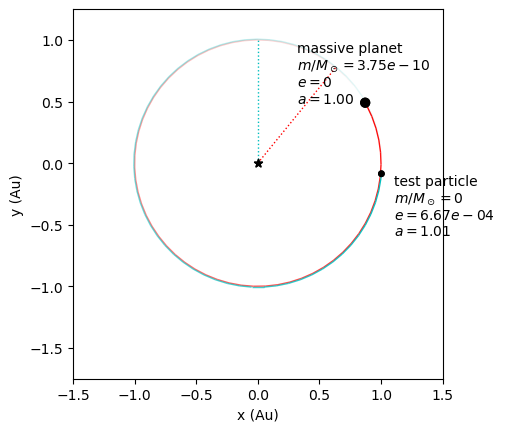

In [4]:
# Run an encounter

# set up integration where conjunction is at time = 0
tmin = -0.905*tconj 
tmax = 0.915*tconj 
Nout = 100000
cor = calculate_phi_correction(phi, etilde, 2, Nout, tmin, tmax)[0]
sim = setup(t0=tmin, phi = phi - cor)
ps = sim.particles
da0 = ps[2].a-ps[1].a # initial diff in a
dr0 = ps[2].a*ps[2].e
conj_idx = 0 # initializing 

Rh = ps[1].a*epsilon # hill radius

# plot initial position of planets
fig, ax = plt.subplots()
ax.set_aspect("equal") 
op = rebound.OrbitPlot(sim, fig=fig, ax=ax, color=True, periastron=True, 
                       xlim=[-1.5,1.5], ylim=[-1.75,1.25])
op.particles.set_sizes([40,15])
ax.annotate('massive planet \n$m/M_\odot={:.2e}$ \n$e=0$ \n$a={:.2f}$'
            .format(mu, ps[1].a), (ps[1].x -.55,ps[1].y))
ax.annotate('test particle \n$m/M_\odot=0$ \n$e={:.2e}$ \n$a={:.2f}$'
            .format(e, ps[2].a), (ps[2].x + ps[1].a/10,ps[2].y-.5))
ax.set(xlabel='x (Au)', ylabel='y (Au)')
#fig.savefig('initial_orbitplot.pdf')

In [5]:
# integrate 


dr, da, dl, dtheta, pomega2, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
times = np.linspace(tmin, tmax, Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    dr[i] = ((ps[2].x - ps[1].x)**2+(ps[2].y - ps[1].y)**2)**0.5
    da[i] = ps[2].a - ps[1].a
    if ps[2].l - ps[1].l > np.pi:
        dl[i] = ps[2].l - ps[1].l - 2*np.pi
    elif ps[2].l - ps[1].l < -np.pi:
        dl[i] = ps[2].l - ps[1].l + 2*np.pi
    else:
        dl[i] = ps[2].l - ps[1].l
    pomega2[i] = ps[2].pomega #pomega of test particle
    phi_arr[i] = ps[2].l - ps[2].pomega

    ## OrbitPlot at conjunction if time is set to conj
    # fig, ax = plt.subplots()
    # ax.set_aspect("equal") 
    # op = rebound.OrbitPlot(sim, particles=[1], fig=fig, ax=ax, color='red', xlim=[-1.5,1.5], ylim=[-1.5,1.5])
    # op = rebound.OrbitPlot(sim, particles=[2], fig=fig, ax=ax, color='blue', xlim=[-1.5,1.5], ylim=[-1.5,1.5])
    # op.particles.set_sizes([10,50])
    # ax.set(xlabel='x (Au)', ylabel='y (Au)', title='Conjunction')
    # fig.tight_layout()
    # fig.savefig('op_true_conj_presentation.png', dpi=300)

daf = ps[2].a-ps[1].a # final diff in a
drf = ps[2].a*ps[2].e

# find the index of conjunciton via min of dl (they are closest exactly at conj)
conj_idx = np.argmin(np.abs(dl)) #this one gives the best matching result
_, da0_plot, daf_plot = calc_Delta_a(da, conj_idx)

In [6]:
print(da0_plot)
print(daf_plot)
print(da0_plot-daf_plot)

0.006722711908361743
0.00672091276050445
1.7991478572926267e-06


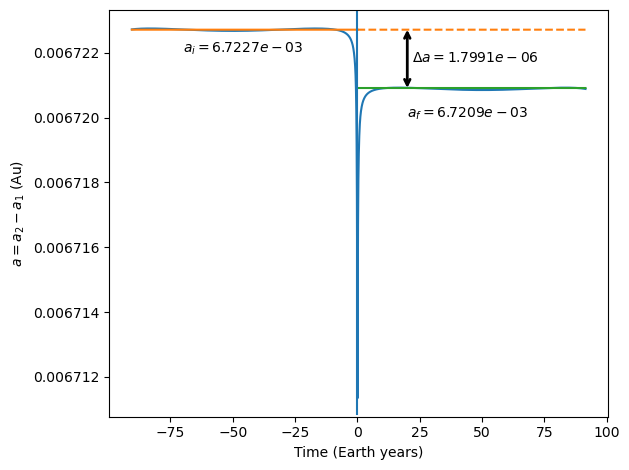

In [7]:
# plot da throughout encounter

fig, ax = plt.subplots()
ax.plot(times, da)
t_before_conj = times[:conj_idx]
t_after_conj = times[conj_idx:]
ax.plot(t_before_conj, np.ones_like(t_before_conj)*da0_plot, label='pre-conjunction')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*da0_plot, c='C1', linestyle='--')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*daf_plot, label='post-conjunction')
ax.axvline(times[conj_idx], da[conj_idx]) # conjunction location
ax.annotate('$a_i={:.4e}$'.format(da0_plot), (-70, .006722))
ax.annotate('$a_f={:.4e}$'.format(daf_plot), (20, .006720))
ax.annotate("", (20, da0_plot), (20, daf_plot), arrowprops={'arrowstyle':'<->','shrinkA':0, 'shrinkB':0,'linewidth':2, 'color':'black'})
ax.annotate('$\Delta a={:.4e}$'.format(da0_plot-daf_plot), (22, .0067217))
ax.set(xlabel='Time (Earth years)', ylabel='$a = a_2 - a_1$ (Au)') #title='Evolution of Relative Semimajor Axis during Conjunction')
#ax.legend()
fig.tight_layout()
#fig.savefig('delta_a.pdf')


In [19]:
# constants
mu1, mu2 = 1.5e-12 *125, 1.5e-12 *125       # m_1/m_star
j, k = 100, 1       # j:j-k MMR (so this is a 20:19 resonance)
pomega1, pomega2 = -np.pi/2, np.pi/2    # pericenter of outer test particle
phi = 2*np.pi/3     # Angle of conjunction relative to pericenter (resonant angle)

n = 2*np.pi         # mean motion of inner planet (is just 2*pi so period = 1)
n20 = n*(j-k)/j     # initial mean motion of outer particle (19/20*n) (at resonance value)
                    # completes 19 orbits in the same time the inner planet completes 20 orbits
dares = (j/(j-k))**(2/3)-1 # delta a_res-- distance between test particle and planet at resonance
deltan = 0          # delta n: deviation of mean motion from resonance
                    # this small value is added to n20 bc the planet isn't *exactly* at resonance

ec = 2*k/3/j        # crossing eccentricity, factor to normalize e
etilde1, etilde2 = 0.05, 0.05        # eccentricity ratio to crossing value (e/e_c)

e1, e2 = etilde1*ec, etilde2*ec       # eccentricity
deltat = 2/3/n20    # time to move delta a in y at a rate delta v, 
                    #   where v = a*delta_n and delta_n = n2-n1
                    #   Goal: to find how far back to integrate

tconj=j/k           # time between conjunctions-- big if delta n is small
# ps[1].P = 1

epsilon = (1/3*(mu1+mu2))**(1/3) # small mass parameter

In [9]:
e2vec = np.array([e2*np.cos(pomega2),e2*np.sin(pomega2)])
e1vec = np.array([e1*np.cos(pomega1),e1*np.sin(pomega1)])
e12 = e2vec-e1vec
ecm = (mu1*e1vec+mu2*e2vec)/(mu1+mu2)
print(e12/ec)
print(ecm/ec)

[0.  0.1]
[3.061617e-18 0.000000e+00]


In [24]:
def setup_gencase(t0=-deltat, theta=None, to_print=True, phi = phi, etilde = etilde): # make sim with sim.t = t0 (where conjunction always happens near t=0, use get_conjunction_time to get exact)
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1)
    sim.add(m=mu1, P=1, e=e1 ,pomega=pomega1,
            l=pomega2+phi+n*t0) # phi = l - pomega, so l = pomega+phi
    ps = sim.particles
    
    if theta is None:
        theta = pomega2+phi+n20*t0
    sim.add(m=mu2, P=2*np.pi/(n20+deltan), e=e2, pomega=pomega2, l=theta)
    sim.t = t0
    return sim

def calculate_phi_correction_gencase(phi_0, etilde, iterations, Nout, tmin, tmax):
    iteration = 0
    correction = 0
    correction_iter = 0
    while iteration <= iterations:
        phi = phi_0 - correction
        sim = setup_gencase(t0 = tmin, phi = phi, etilde = etilde)
        ps = sim.particles
        dl, pomega2, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
        times = np.linspace(tmin, tmax, Nout)
        for i, time in enumerate(times):
            sim.integrate(time)
            if ps[2].l - ps[1].l > np.pi:
                dl[i] = ps[2].l - ps[1].l - 2*np.pi
            elif ps[2].l - ps[1].l < -np.pi:
                dl[i] = ps[2].l - ps[1].l + 2*np.pi
            else:
                dl[i] = ps[2].l - ps[1].l
            pomega2[i] = ps[2].pomega #pomega of test particle
            phi_arr[i] = ps[2].l - ps[2].pomega
        conj_idx = np.argmin(np.abs(dl))
        #print (phi)
        correction = phi_arr[conj_idx] - phi
        #print (correction)
        correction_iter = phi_arr[conj_idx] - phi_0
        #print (correction_iter)
        iteration += 1
    return correction, correction_iter # (correction angle and the deviation from the actual phi)

[Text(0.5, 0, 'x (Au)'), Text(0, 0.5, 'y (Au)')]

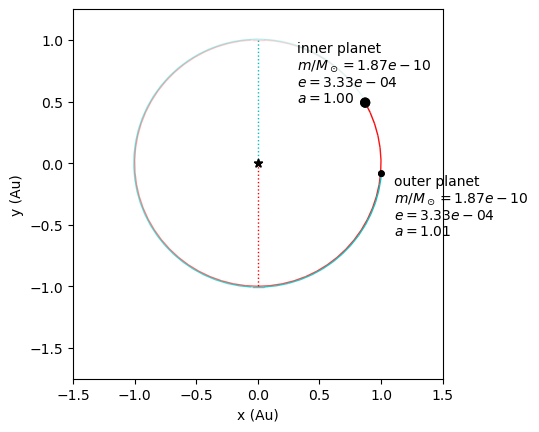

In [25]:
# Run an encounter

# set up integration where conjunction is at time = 0
tmin = -0.905*tconj 
tmax = 0.915*tconj 
Nout = 100000
cor = calculate_phi_correction_gencase(phi, 0.1, 2, Nout, tmin, tmax)[0]
sim = setup_gencase(t0=tmin, phi = phi - cor)
ps = sim.particles
da0 = ps[2].a-ps[1].a # initial diff in a
dr0 = ps[2].a*ps[2].e
conj_idx = 0 # initializing 

Rh = ps[1].a*epsilon # hill radius

# plot initial position of planets
fig, ax = plt.subplots()
ax.set_aspect("equal") 
op = rebound.OrbitPlot(sim, fig=fig, ax=ax, color=True, periastron=True, 
                       xlim=[-1.5,1.5], ylim=[-1.75,1.25])
op.particles.set_sizes([40,15])
ax.annotate('inner planet \n$m/M_\odot={:.2e}$ \n$e={:.2e}$ \n$a={:.2f}$'
            .format(mu1, e1, ps[1].a), (ps[1].x -.55,ps[1].y))
ax.annotate('outer planet \n$m/M_\odot={:.2e}$ \n$e={:.2e}$ \n$a={:.2f}$'
            .format(mu2, e2, ps[2].a), (ps[2].x + ps[1].a/10,ps[2].y-.5))
ax.set(xlabel='x (Au)', ylabel='y (Au)')
#fig.savefig('initial_orbitplot.pdf')

In [26]:
# integrate 


dr, da, dl, dtheta, pomega2, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
times = np.linspace(tmin, tmax, Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    dr[i] = ((ps[2].x - ps[1].x)**2+(ps[2].y - ps[1].y)**2)**0.5
    da[i] = ps[2].a - ps[1].a
    if ps[2].l - ps[1].l > np.pi:
        dl[i] = ps[2].l - ps[1].l - 2*np.pi
    elif ps[2].l - ps[1].l < -np.pi:
        dl[i] = ps[2].l - ps[1].l + 2*np.pi
    else:
        dl[i] = ps[2].l - ps[1].l
    pomega2[i] = ps[2].pomega #pomega of test particle
    phi_arr[i] = ps[2].l - ps[2].pomega

    ## OrbitPlot at conjunction if time is set to conj
    # fig, ax = plt.subplots()
    # ax.set_aspect("equal") 
    # op = rebound.OrbitPlot(sim, particles=[1], fig=fig, ax=ax, color='red', xlim=[-1.5,1.5], ylim=[-1.5,1.5])
    # op = rebound.OrbitPlot(sim, particles=[2], fig=fig, ax=ax, color='blue', xlim=[-1.5,1.5], ylim=[-1.5,1.5])
    # op.particles.set_sizes([10,50])
    # ax.set(xlabel='x (Au)', ylabel='y (Au)', title='Conjunction')
    # fig.tight_layout()
    # fig.savefig('op_true_conj_presentation.png', dpi=300)

daf = ps[2].a-ps[1].a # final diff in a
drf = ps[2].a*ps[2].e

# find the index of conjunciton via min of dl (they are closest exactly at conj)
conj_idx = np.argmin(np.abs(dl)) #this one gives the best matching result
_, da0_gen_plot, daf_gen_plot = calc_Delta_a(da, conj_idx)

In [27]:
print(da0_gen_plot)
print(daf_gen_plot)
print(da0_gen_plot-daf_gen_plot)

0.006722711990252627
0.0067209285830834705
1.7834071691568906e-06


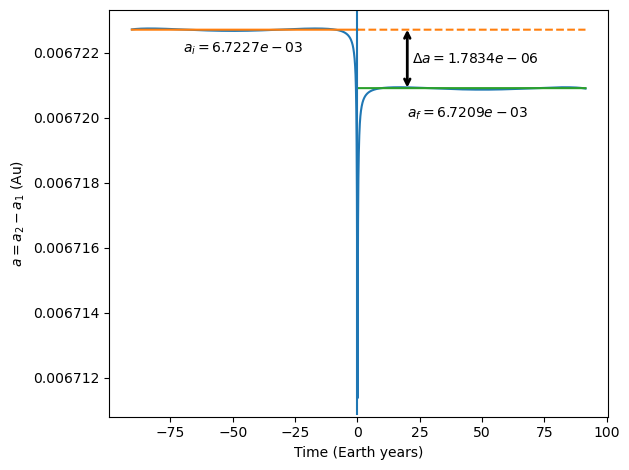

In [28]:
# plot da throughout encounter

fig, ax = plt.subplots()
ax.plot(times, da)
t_before_conj = times[:conj_idx]
t_after_conj = times[conj_idx:]
ax.plot(t_before_conj, np.ones_like(t_before_conj)*da0_plot, label='pre-conjunction')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*da0_plot, c='C1', linestyle='--')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*daf_plot, label='post-conjunction')
ax.axvline(times[conj_idx], da[conj_idx]) # conjunction location
ax.annotate('$a_i={:.4e}$'.format(da0_gen_plot), (-70, .006722))
ax.annotate('$a_f={:.4e}$'.format(daf_gen_plot), (20, .006720))
ax.annotate("", (20, da0_gen_plot), (20, daf_gen_plot), arrowprops={'arrowstyle':'<->','shrinkA':0, 'shrinkB':0,'linewidth':2, 'color':'black'})
ax.annotate('$\Delta a={:.4e}$'.format(da0_gen_plot-daf_gen_plot), (22, .0067217))
ax.set(xlabel='Time (Earth years)', ylabel='$a = a_2 - a_1$ (Au)') #title='Evolution of Relative Semimajor Axis during Conjunction')
#ax.legend()
fig.tight_layout()
#fig.savefig('delta_a.pdf')